In [234]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import sys
%matplotlib inline
sns.set()

In [297]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
x = data['X']
y = (np.zeros(50000)).reshape(5000, 10)
initialTheta = np.concatenate((weights['Theta1'].flatten(), theta2.flatten()), axis = 0).reshape(-1, 1)
theta1 = initialTheta[:10025].reshape(25, 401)
theta2 = initialTheta[10025:].reshape(10, 26)

In [298]:
for number in range(0, 10):
    if number == 0:
        y[0:500, 9:] = 1
    else:
        y[number * 500:(number + 1) * 500, number - 1:number] = 1

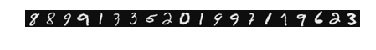

In [299]:
sample = np.random.choice(x.shape[0], 20)
plt.imshow(x[sample, :].reshape(-1, 20).T, cmap='gray')
plt.axis('off');

In [300]:
def sigmoidFunction (z):
    return 1 / (1 + np.exp(-z))

In [301]:
def hypothesisFunction (x, theta):
    theta1 = theta[:10025].reshape(25, 401)
    theta2 = theta[10025:].reshape(10, 26)
    
    a1 = np.c_[np.ones((x.shape[0], 1)), x]
    z2 = np.dot(a1, theta1.T)
    
    a2 = np.c_[np.ones((x.shape[0], 1)), sigmoidFunction(z2)]
    z3 = np.dot(a2, theta2.T)
    
    a3 = sigmoidFunction(z3)
    return dict([('a3', a3), ('z2', z2), ('a2', a2), ('a1', a1)])

In [302]:
def costFunction (y, h):
    m = y.shape[0]
    j = (1 / m) * (np.log(h).T.dot(-y) - np.log(1 - h).T.dot(1 - y))
    costs = []
    for number in range(10):
        costs.append(j[number, number])
    mainCosts = np.array(costs)
    return mainCosts

In [303]:
costFunction (y, hypothesisFunction(x, initialTheta)['a3'])

array([ 0.02115448,  0.03022682,  0.03946314,  0.02972325,  0.02998443,
        0.02026629,  0.028228  ,  0.03474724,  0.03946383,  0.0143717 ])

In [304]:
def regularizedCostFunction (costs, theta, λ = 0.1):
    theta1 = theta[:10025].reshape(25, 401)
    theta2 = theta[10025:].reshape(10, 26)
    m = y.shape[0]
    costs += ((λ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))))
    return costs

In [305]:
sum(regularizedCostFunction (costFunction (y, hypothesisFunction(x, initialTheta)['a3']), initialTheta, 0.1))

0.38376985909092359

In [306]:
def sigmoidGradient (z):
    return sigmoidFunction(z) * (1 - sigmoidFunction(z))

In [316]:
randomTheta = np.random.uniform(low = -0.12, high = 0.12, size = (10285, 1))

array([-0.05972372,  0.10524662, -0.115168  , ..., -0.0044864 ,
       -0.07644725,  0.04905624])

In [308]:
def backPropagationFunction (y, h, theta):
    m = y.shape[0]
    theta2 = theta[10025:].reshape(10, 26)
    a3 = h['a3']
    z2 = h['z2']
    a2 = h['a2']
    a1 = h['a1']
    𝛿3 = a3 - y
    𝛿2 = np.dot(𝛿3, theta2)[:, 1:] * sigmoidGradient(z2)
    Δ2 = np.dot(a2.T, 𝛿3)
    Δ1 = np.dot(a1.T, 𝛿2)
    D2 = 1 / m * Δ2
    D1 = 1 / m * Δ1
    return D1, D2

In [309]:
def computeNumericalGradient (theta1, theta2, ϵ):
    f = []
    epsilonVector1 = np.zeros((25, 401))
    for number1 in np.nditer(epsilonVector1, op_flags=['readwrite']):
        number1 += ϵ
        theta1Plus = theta1 + epsilonVector1
        theta1Minus = theta1 - epsilonVector1
        jPlus = costFunction (y[:500], hypothesisFunction(x[:500], theta1Plus, theta2)['a3'])
        jMinus = costFunction (y[:500], hypothesisFunction(x[:500], theta1Minus, theta2)['a3'])
        f.append((jPlus + jMinus) / (2 * ϵ))
        number1 -= ϵ
    epsilonVector2 = np.zeros((10, 26))
    for number2 in np.nditer(epsilonVector2, op_flags=['readwrite']):
        number2 += ϵ
        theta2Plus = theta2 + epsilonVector2
        theta2Minus = theta2 - epsilonVector2
        jPlus = costFunction (y[:500], hypothesisFunction(x[:500, :], theta1, theta2Plus)['a3'])
        jMinus = costFunction (y[:500], hypothesisFunction(x[:500, :], theta1, theta2Minus)['a3'])
        f.append((jPlus + jMinus) / (2 * ϵ))
        number2 -= ϵ
    return np.array(f)

In [310]:
def regularizedBackPropagationFunction (backPropagationFunction, theta, m, λ = 1):
    theta1 = initialTheta[:10025].reshape(25, 401)
    theta2 = initialTheta[10025:].reshape(10, 26)
    
    D1 = backPropagationFunction[0]
    D1 = D1.T[:, 1:] + (λ / m) * theta1[:, 1:]
    
    D2 = backPropagationFunction[1]
    D2 = D2.T[:, 1:] + (λ / m) * theta2[:, 1:]
    return D1, D2

In [318]:
def optimize (cost, theta, backPropagationFunction, x, y, λ):
    return sc.optimize.minimize(cost, theta, args = (x, y, λ), method = 'CG', jac = backPropagationFunction, options = {'maxiter':50, 'disp':True})

In [319]:
h = hypothesisFunction(x, randomTheta)
cost = costFunction(y, h['a3'])
backPropagation = regularizedBackPropagationFunction(backPropagationFunction(y, h, randomTheta), randomTheta, 5000, λ = 1)
optimize(cost, randomTheta.flatten(), backPropagation, x.flatten(), y.flatten(), 0.1)

TypeError: 'numpy.ndarray' object is not callable